In [ ]:
import glob
import networkx as nx
from textblob import TextBlob
from typing import List, Dict, Any
import matplotlib.pyplot as plt
from grakel.kernels import WeisfeilerLehman, VertexHistogram
import numpy as np

from networkx.algorithms import community as communitydetect
import community as community_louvain
import igraph as ig

In [ ]:
def create_edge_dictionary(G):
    edge_dict = {}
    for node in G.nodes():
        edge_dict[node] = {}
        
        for neighbor in G.neighbors(node):
            edge_dict[node][neighbor] = 0
            
    return edge_dict

def create_node_labels(G):
    node_labels = {node: node for node in G.nodes()}
    return node_labels

def convert_to_grakel_format_with_edge_dict(G):
    edge_dict = create_edge_dictionary(G)
    node_labels = create_node_labels(G)
    return edge_dict, node_labels

In [ ]:
wl_kernel = WeisfeilerLehman(base_graph_kernel=VertexHistogram, normalize=True)
list_of_graphs = glob.glob(r"C:\Users\arjun\Downloads\v2\graphs\*\*.graphml")
graphs = []
for graph in list_of_graphs:
    nx_graph = nx.read_graphml(graph)
    if nx_graph.number_of_nodes() == 0 or nx_graph.number_of_edges() == 0:
        continue
    grakel_graph = convert_to_grakel_format_with_edge_dict(nx_graph)
    graphs.append(grakel_graph)

similarity_matrix = wl_kernel.fit_transform(graphs)

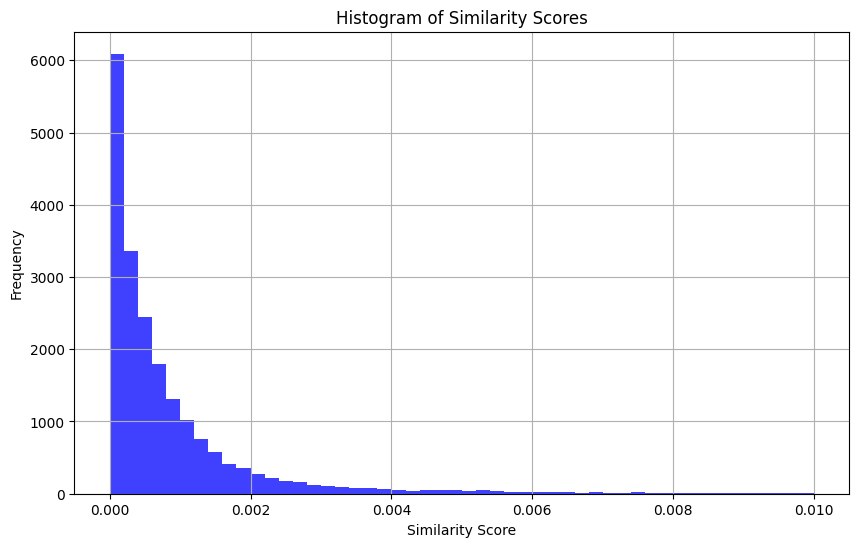

In [ ]:
similarity_matrix = np.array(similarity_matrix)
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2

np.fill_diagonal(similarity_matrix, 0) # Remove self-similarities

# Flatten the matrix and remove zero values (self-similarities already removed)
similarity_scores = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=50, alpha=0.75, color='blue', range=(0, 0.01))
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

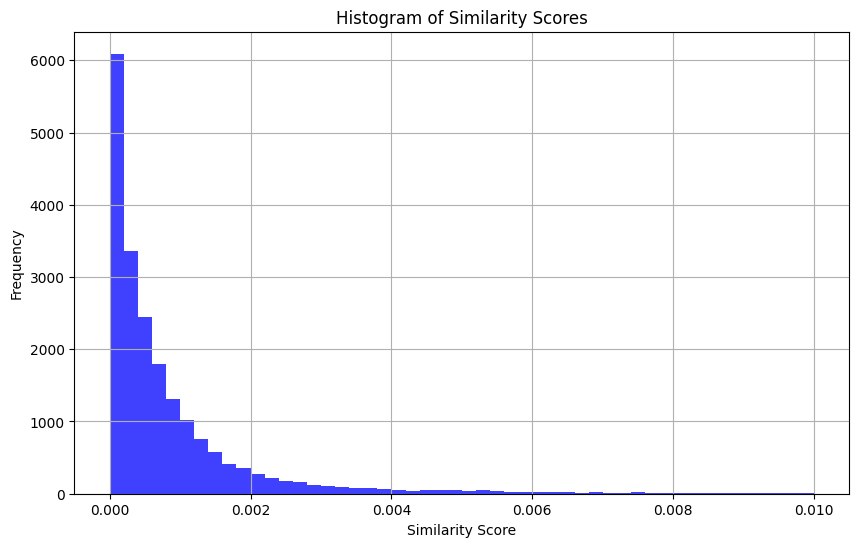

In [ ]:
similarity_matrix = np.array(similarity_matrix)
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2

np.fill_diagonal(similarity_matrix, 0) # Remove self-similarities

# Flatten the matrix and remove zero values (self-similarities already removed)
similarity_scores = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=50, alpha=0.75, color='blue', range=(0, 0.01))
plt.title('Histogram of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
five = np.percentile(similarity_matrix, 5)
ninety_five = np.percentile(similarity_matrix, 95)


inflection_points = np.append(inflection_points, [ninety_five, 0.004])

In [ ]:
graphs = {}
for threshold in inflection_points:
    G = nx.Graph()

    for graph in list_of_graphs:
        G.add_node(graph)

    for i in range(len(similarity_matrix)):
        for j in range(i + 1, len(similarity_matrix)):
            # avg_sentiment = (find_avg_sentiment(working_set[i]) + find_avg_sentiment(working_set[j])) // 2
            if similarity_matrix[i][j] > threshold:
                G.add_edge(list_of_graphs[i], list_of_graphs[j], weight=similarity_matrix[i][j])

    graphs[threshold] = G

In [ ]:
true_categories = {
    list_of_graphs[i].split("\\")[-1].split(".")[0] : list_of_graphs[i].split("\\")[-2] for i in range(len(list_of_graphs))
}

In [ ]:
def community_detection_louvain(G):
    partition = community_louvain.best_partition(G)
    sorted_partition = sorted(partition.items(), key=lambda kv: kv[1])
    partition_dict = {}
    for k, v in sorted_partition:
        if v not in partition_dict:
            partition_dict[v] = []
        partition_dict[v].append(k)
    
    return partition_dict 

In [ ]:
def community_detection_girvan_newman(G):
    communities_generator = communitydetect.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    sorted(map(sorted, next_level_communities))
    partition_dict = {}
    for i, community in enumerate(next_level_communities):
        for node in community:
            if i not in partition_dict:
                partition_dict[i] = []
            partition_dict[i].append(node)
    partition = {}
    for k, v in partition_dict.items():
        for node in v:
            partition[node] = k

    
    return partition_dict

In [ ]:
def community_detection_label_propagation(G):
    communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
    communities_list = list(communities)
    partition_dict = {}
    for i, community in enumerate(communities_list):
        partition_dict[i] = list(community)
    partition = {}
    for k, v in partition_dict.items():
        for node in v:
            partition[node] = k
    return partition_dict

In [ ]:
def community_detection_fast_greedy(G):
    ig_graph = ig.Graph(directed=False)
    ig_graph.add_vertices(list(G.nodes()))
    ig_graph.add_edges(list(G.edges()))
    communities = ig_graph.community_fastgreedy()
    clusters = communities.as_clustering()
    partition_dict = {}
    for i, community in enumerate(clusters):
        partition_dict[i] = [list(G.nodes())[node] for node in community]
    partition = {}
    for k, v in partition_dict.items():
        for node in v:
            partition[node] = k
    
    return partition_dict

In [ ]:
def community_detection_leading_eigenvector(G):
    ig_graph = ig.Graph(directed=False)
    ig_graph.add_vertices(list(G.nodes()))
    ig_graph.add_edges(list(G.edges()))
    communities = ig_graph.community_leading_eigenvector()
    partition_dict = {}
    for i, community in enumerate(communities):
        partition_dict[i] = [list(G.nodes())[node] for node in community]
    partition = {}
    for k, v in partition_dict.items():
        for node in v:
            partition[node] = k

    return partition_dict

In [ ]:
def community_detection_walktrap(G):
    ig_graph = ig.Graph(directed=False)
    ig_graph.add_vertices(list(G.nodes()))
    ig_graph.add_edges(list(G.edges()))
    communities = ig_graph.community_walktrap()
    clusters = communities.as_clustering()
    partition_dict = {}
    for i, community in enumerate(clusters):
        partition_dict[i] = [list(G.nodes())[node] for node in community]
    partition = {}
    for k, v in partition_dict.items():
        for node in v:
            partition[node] = k
    
    return partition_dict

In [ ]:
def remove_outliers(partition_dict):
    temporary_partition_dict = partition_dict.copy()
    community_sizes = np.array([len(v) for v in partition_dict.values() if len(v) > 1])
    Q1 = np.percentile(community_sizes, 25)
    Q3 = np.percentile(community_sizes, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    partition_dict = {k: v for k, v in partition_dict.items() if len(v) >= lower_bound and len(v) <= upper_bound and len(v) > 1}
    return partition_dict, temporary_partition_dict

In [ ]:
from collections import Counter

def get_homogeneity_scores(partition_dict):
    mean_homogeneity = 0
    median_homogeneity = 0
    homogeneity_scores = {}
    for community_id, subreddits in partition_dict.items():
        categories = [true_categories[subreddit.split("\\")[-1].split(".")[0]] for subreddit in subreddits if subreddit.split("\\")[-1].split(".")[0] in true_categories]
        category_counts = Counter(categories)

        if category_counts:
            most_common_category, most_common_count = category_counts.most_common(1)[0]
            homogeneity = most_common_count / len(categories)

        else:
            homogeneity = 0

        homogeneity_scores[community_id] = homogeneity

    mean_homogeneity = np.mean(list(homogeneity_scores.values()))
    median_homogeneity = np.median(list(homogeneity_scores.values()))
    return mean_homogeneity, median_homogeneity

In [ ]:
community_detection_algorithms = ['louvain', 'girvan_newman', 'label_propagation', 'fast_greedy', 'leading_eigenvector', 'walktrap']

In [ ]:
def validate_partition(G, partition):
    """ Ensure every node is covered exactly once in the partition. """
    all_nodes = set(G.nodes())
    covered_nodes = set()
    for community in partition:
        if not community:  # Skip empty communities if any
            continue
        community_set = set(community)
        if not covered_nodes.isdisjoint(community_set):
            raise ValueError("Overlap detected in communities")
        covered_nodes.update(community_set)

    if covered_nodes != all_nodes:
        raise ValueError("Partition does not cover all nodes")

In [ ]:
mean_homogeneity_scores = {
    algorithm: {} for algorithm in community_detection_algorithms
}

modularity_scores = {
    algorithm: {} for algorithm in community_detection_algorithms
}

median_homogeneity_scores = {
    algorithm: {} for algorithm in community_detection_algorithms
}


for algorithm in community_detection_algorithms:
    for threshold, G in graphs.items():
        try:
            if algorithm == 'louvain':
                partition = community_detection_louvain(G)
            elif algorithm == 'girvan_newman':
                partition = community_detection_girvan_newman(G)
            elif algorithm == 'label_propagation':
                partition = community_detection_label_propagation(G)
            elif algorithm == 'fast_greedy':
                partition = community_detection_fast_greedy(G)
            elif algorithm == 'leading_eigenvector':
                partition = community_detection_leading_eigenvector(G)
            elif algorithm == 'walktrap':
                partition = community_detection_walktrap(G)
        except Exception as e:
            print(f"Error: {algorithm} {threshold} {e}")
            continue

        partition, original = remove_outliers(partition)
        print(partition)
        if len(partition) <= 1:
            continue
        mean_homogeneity, median_homogeneity = get_homogeneity_scores(partition)
        mean_homogeneity_scores[algorithm][threshold] = mean_homogeneity
        median_homogeneity_scores[algorithm][threshold] = median_homogeneity

        # calculate modularity
        validate = validate_partition(G, [list(v) for v in original.values()])
        modularity = communitydetect.modularity(G, [list(v) for v in original.values()])
        print(f"{algorithm} {threshold} {modularity} {mean_homogeneity} {median_homogeneity}")
        modularity_scores[algorithm][threshold] = modularity


{0: ['../new/graphs\\guns\\airsoft.graphml', '../new/graphs\\guns\\ar15.graphml', '../new/graphs\\guns\\army.graphml', '../new/graphs\\guns\\ccw.graphml', '../new/graphs\\guns\\combatfootage.graphml', '../new/graphs\\guns\\firearms.graphml', '../new/graphs\\guns\\gundeals.graphml', '../new/graphs\\guns\\gunporn.graphml', '../new/graphs\\guns\\guns.graphml', '../new/graphs\\guns\\GunsAreCool.graphml', '../new/graphs\\guns\\justbootthings.graphml', '../new/graphs\\guns\\military.graphml', '../new/graphs\\guns\\militarygfys.graphml', '../new/graphs\\guns\\PhillyGuns.graphml', '../new/graphs\\guns\\warshipporn.graphml', '../new/graphs\\politics\\conservative.graphml', '../new/graphs\\politics\\politicaldiscussion.graphml', '../new/graphs\\sports\\olympics.graphml'], 1: ['../new/graphs\\guns\\Argmas.graphml', '../new/graphs\\guns\\AUSguns.graphml', '../new/graphs\\guns\\BayAreaGunMeetups.graphml', '../new/graphs\\guns\\Illinoisccw.graphml', '../new/graphs\\guns\\MilitaryPorn.graphml', '../n

In [ ]:
print(mean_homogeneity_scores)
print(median_homogeneity_scores)

{'louvain': {0.001951951951951952: 0.794798917041564, 0.006196196196196196: 0.8911444132308795, 0.008788788788788788: 0.8798347621877033, 0.00036036036036036037: 0.7740379545713634, 0.005385385385385385: 0.8918608352431883, 0.007877877877877878: 0.9181147731082107, 0.009979979979979979: 0.9119436088194884, 0.0038753488218079978: 0.9010119479890721, 0.004: 0.8910063558696589}, 'girvan_newman': {0.006196196196196196: 0.6645559845559845, 0.008788788788788788: 0.8112115065461922, 0.005385385385385385: 0.7086020797683297, 0.007877877877877878: 0.736111111111111, 0.009979979979979979: 1.0, 0.0038753488218079978: 0.5973725490196079, 0.004: 0.5973725490196079}, 'label_propagation': {0.006196196196196196: 0.9163798852874484, 0.008788788788788788: 0.9540229885057471, 0.005385385385385385: 0.9216494290023702, 0.007877877877877878: 0.8978893210176633, 0.009979979979979979: 0.9691358024691357, 0.0038753488218079978: 0.8029761904761905, 0.004: 0.7938775510204081}, 'fast_greedy': {0.00195195195195195

In [ ]:

def aux_func(algo_names, data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=False)  # Removed sharey=True for different y scales
    axes = axes.flatten()  # Flatten the array of axes for easier iteration
    for idx, algo in enumerate(algo_names):
        thresholds = np.array(list(data[algo].keys()))
        homogeneities = np.array(list(data[algo].values()))
        modularities = np.array([modularity_scores[algo][threshold] for threshold in data[algo].keys()])

        # Sorting data for plotting
        sorted_indices = np.argsort(thresholds)
        thresholds = thresholds[sorted_indices]
        homogeneities = homogeneities[sorted_indices]
        modularities = modularities[sorted_indices]

        # Fit a smooth line for homogeneity
        z_homogeneity = np.polyfit(thresholds, homogeneities, 3)  # Cubic polynomial
        p_homogeneity = np.poly1d(z_homogeneity)
        smooth_homogeneities = p_homogeneity(thresholds)

        # Fit a smooth line for modularity
        z_modularity = np.polyfit(thresholds, modularities, 3)  # Cubic polynomial
        p_modularity = np.poly1d(z_modularity)
        smooth_modularities = p_modularity(thresholds)

        # Plotting each algorithm's homogeneity data
        axes[idx].scatter(thresholds, homogeneities, color='blue', label='Homogeneity Points')
        axes[idx].plot(thresholds, smooth_homogeneities, 'b-', label='Smooth Homogeneity Curve')

        # Plotting each algorithm's modularity data
        axes[idx].plot(thresholds, modularities, 'g^', label='Modularity Points')
        axes[idx].plot(thresholds, smooth_modularities, 'g--', label='Smooth Modularity Curve')
        max_homogeneity = max(homogeneities)
        max_index = np.argmax(homogeneities)
        max_threshold = thresholds[max_index]
        axes[idx].scatter(max_threshold, max_homogeneity, color='red', edgecolor='black', zorder=5)  # Higher zorder to draw on top
        axes[idx].annotate(f'{max_homogeneity:.4f}', (max_threshold, max_homogeneity),
                            textcoords="offset points", xytext=(0,10), ha='center')

        axes[idx].set_title(algo)
        axes[idx].set_xlabel('Threshold')
        axes[idx].set_ylabel('Scores')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

def plot(data):
    algo_names = list(data.keys())
    algo_names = [algo_names[:2], algo_names[2:4], algo_names[4:]]
    for algo in algo_names:
        aux_func(algo, data)



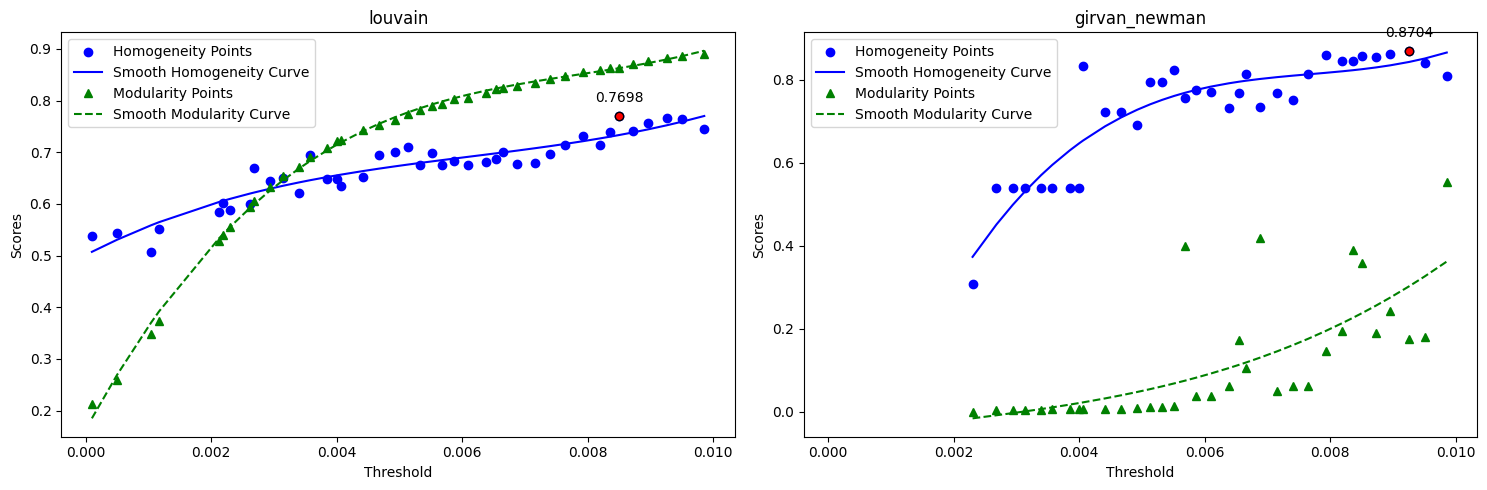

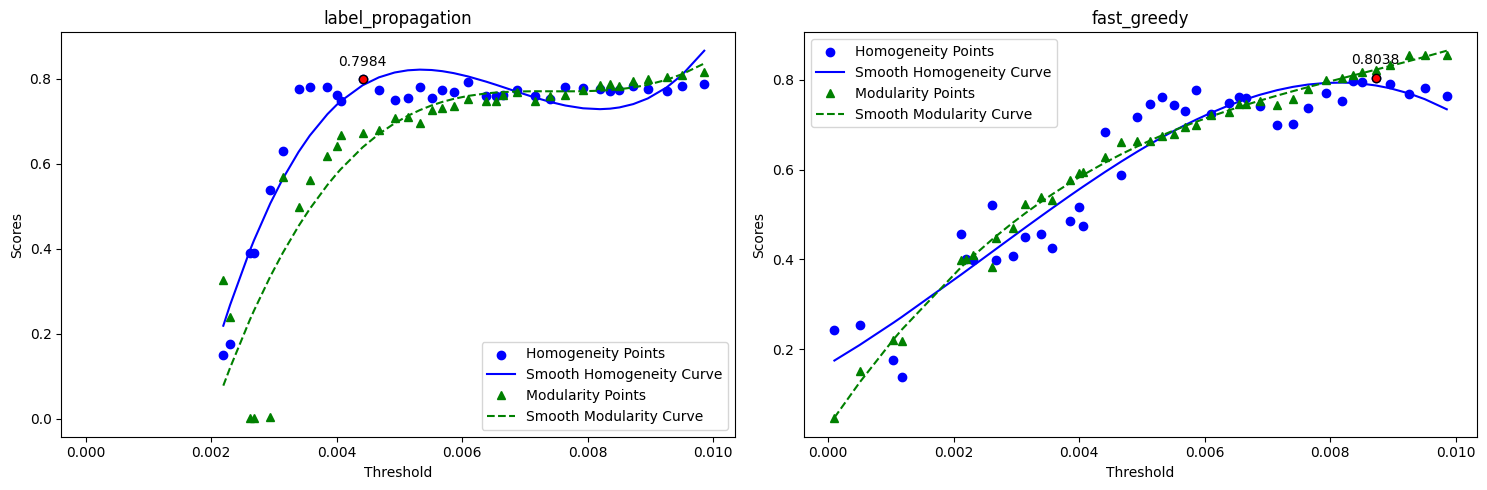

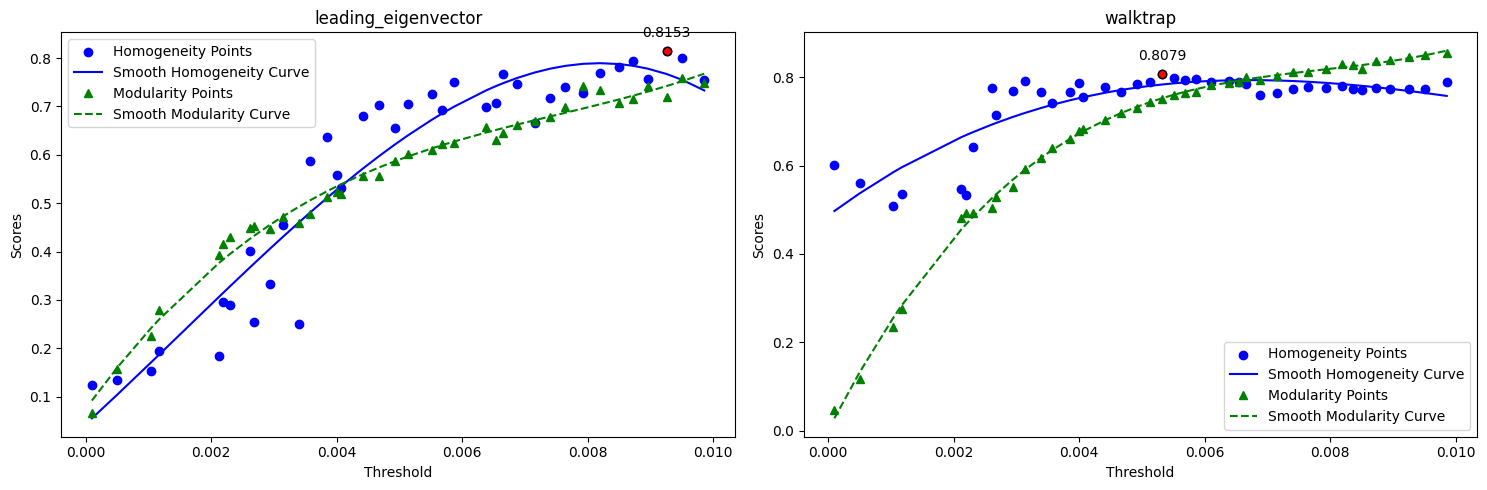

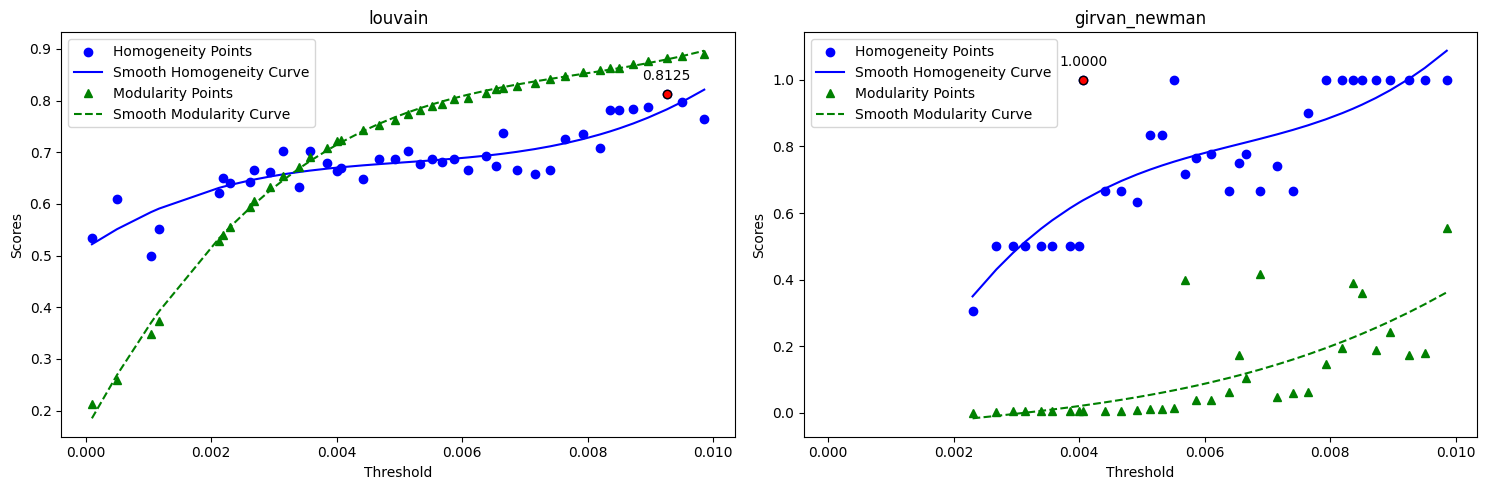

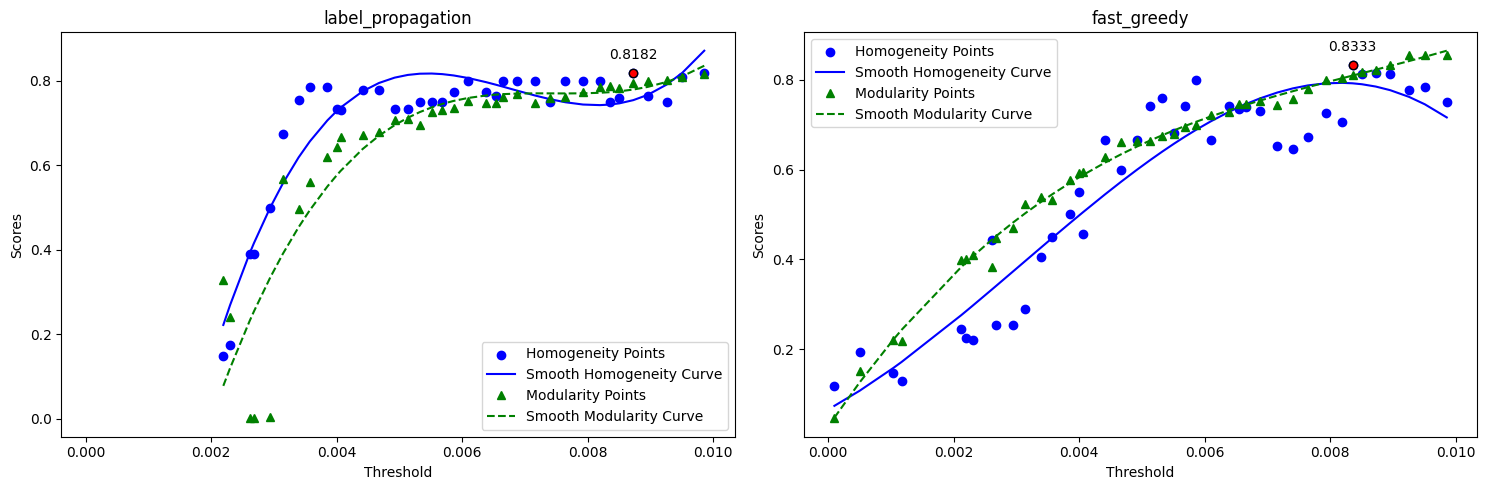

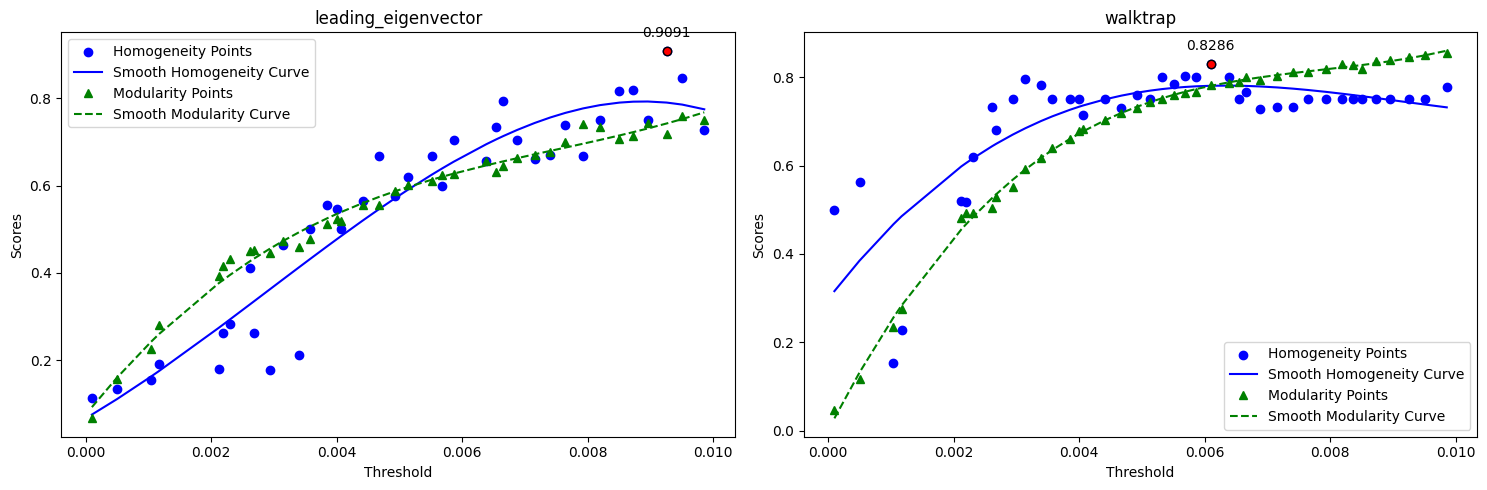

In [ ]:
plot(mean_homogeneity_scores)
plot(median_homogeneity_scores)